In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE
from utils import load_csv_data, plot_pca
from sklearn.decomposition import PCA

In [2]:
X_train_cat,X_test_cat,y_train_cat,y_test_cat = load_csv_data('imbalanced_dataset_cat')

## Adasyn Oversampling

In [3]:
print(f'Before oversampling: {np.unique(y_train_cat, return_counts=True)}')
ada = ADASYN(random_state=8, n_jobs=-1, n_neighbors=5)
X_train, y_train = ada.fit_resample(X_train_cat, y_train_cat)
print(f'After oversampling{np.unique(y_train, return_counts=True)}')

Before oversampling: (array([0, 1], dtype=int64), array([57600,  5436], dtype=int64))


c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


After oversampling(array([0, 1], dtype=int64), array([57600, 58221], dtype=int64))


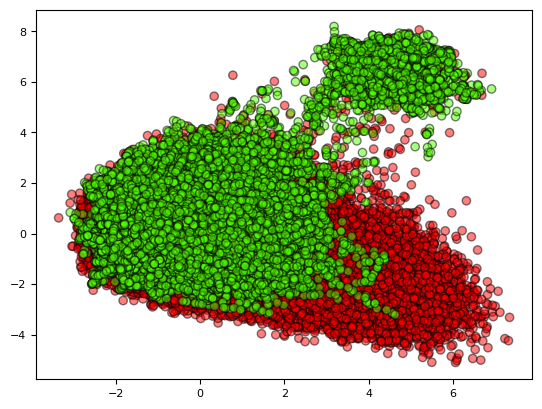

In [4]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
plot_pca(X_train_pca, y_train)

## Model Selection

In [5]:
from sklearn.model_selection import RandomizedSearchCV
# DECISION TREE
parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24,26,30,35,40,45,50,55,60,70,80,90,100,110,120,140]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = RandomizedSearchCV(
    dtc, 
    parameters,
    n_iter=500,
    scoring='f1_macro', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
selected = clf.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
DecisionTreeClassifier(max_depth=55, random_state=8)
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 55, 'criterion': 'gini'}
0.8445579118882375


In [6]:
# decision tree selected model
model = DecisionTreeClassifier(max_depth=55, random_state=8)
y_pred = cross_val_predict(model, X_train, y_train, cv=5)
y_pred_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')

print(classification_report(y_train, y_pred))
#plot_roc(y_train, y_pred_proba)
#plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
#plt.show()

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     57600
           1       0.84      0.85      0.85     58221

    accuracy                           0.84    115821
   macro avg       0.84      0.84      0.84    115821
weighted avg       0.84      0.84      0.84    115821



In [16]:
feat_dec = {i:attr for attr,i in zip(X_train_cat.columns, range(len(list(X_train_cat.columns))))}
model =DecisionTreeClassifier(max_depth=55, random_state=8)
model.fit(X_train, y_train)
feature_importance = [{'name': name, 'importance': imp} for name, imp in zip(X_train_cat.columns, model.feature_importances_)]
feature_importance = sorted(feature_importance, key= lambda x: x['importance'], reverse=True)
pd.DataFrame(feature_importance[:20])

,name,importance
0,speechiness,0.217390
1,instrumentalness,0.063424
2,danceability,0.048468
3,duration_ms,0.048159
4,loudness,0.047994
5,time_signature_confidence,0.047151
6,acousticness,0.044853
7,valence,0.044732
8,energy,0.043395
9,popularity,0.036549


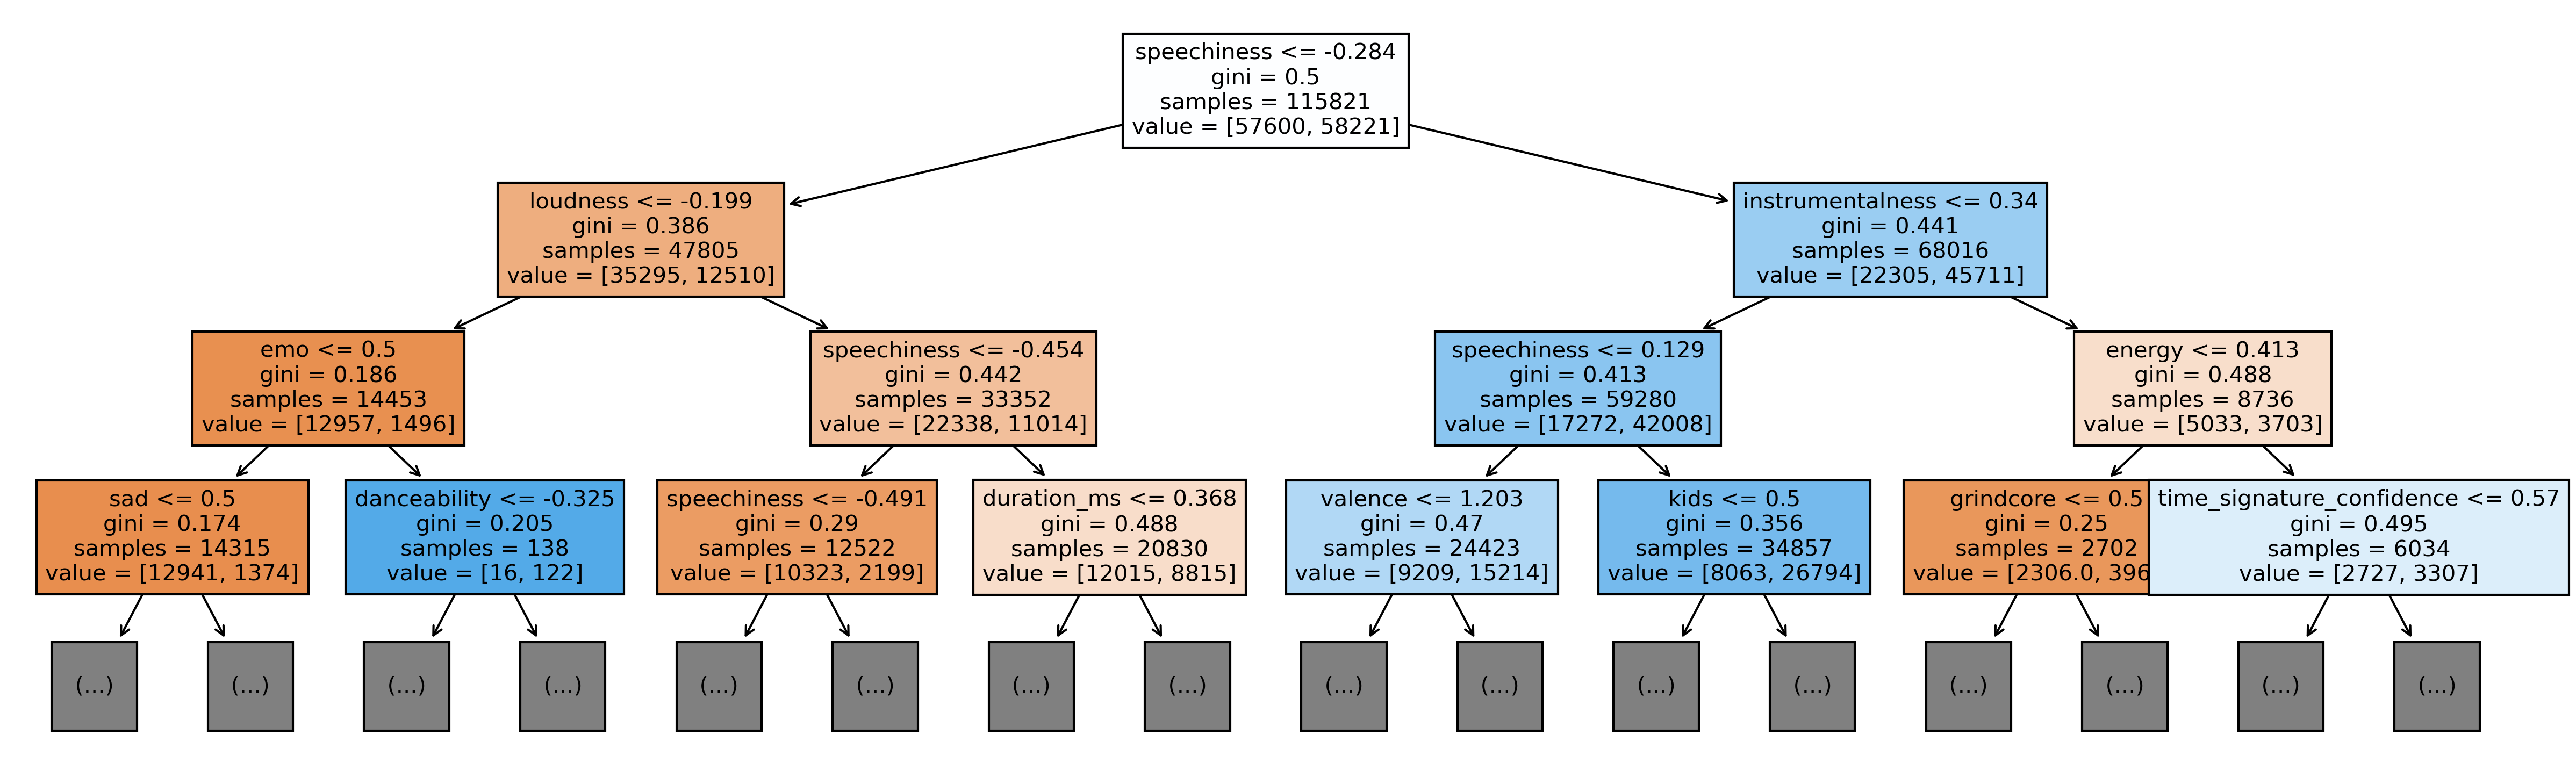

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 6), dpi=300)
plot_tree(model, feature_names=X_train_cat.columns, filled=True, max_depth=3, fontsize=10)
plt.show()

## Test

              precision    recall  f1-score   support

           0       0.94      0.85      0.89     19201
           1       0.22      0.46      0.30      1812

    accuracy                           0.82     21013
   macro avg       0.58      0.65      0.60     21013
weighted avg       0.88      0.82      0.84     21013



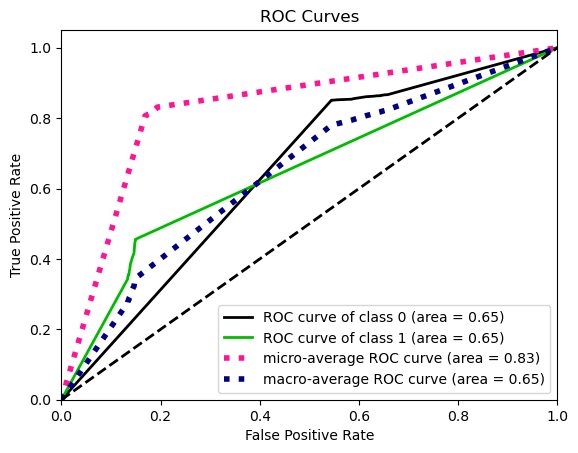

In [19]:
model = DecisionTreeClassifier(max_depth=55, random_state=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_cat)
y_pred_proba = model.predict_proba(X_test_cat)

print(classification_report(y_test_cat, y_pred))
plot_roc(y_test_cat, y_pred_proba)
plt.legend(loc='lower right',prop={'size': 10})
plt.show()